In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



FIG_W = 6.8
FIG_H = 5.5

plt.figure(figsize=(FIG_W,FIG_H))


# sns.set_context("paper")
sns.set_style("whitegrid", {'axes.grid' : False})


def rename_columns(col):
    try:
        col = col.split('rank')[1].split(' ')[0]
    except:
        pass
    return col

def preprocess_df(path,
                  drop_columns=[],
                  alpha=0.99,
                  take_every=10,
                  max_len=1001,
                  transform_other=None,
                  transform_self=None,
                  other_slice=slice(0),
                  self_slice=slice(0),
                  ylabel='Relative rate'
                 ):
    df = pd.read_csv(path)
    index = df.iloc[:, 0]
    df_cr_self = df.iloc[:max_len:take_every,::2]
    df_cr_other = df.iloc[:max_len:take_every,1::2]
    
    df_cr_self.columns = list(map(rename_columns, df_cr_self.columns))
    df_cr_other.columns = list(map(rename_columns, df_cr_other.columns))
    
    df_cr_self = df_cr_self.drop(labels=drop_columns, axis=1)
    df_cr_other = df_cr_other.drop(labels=drop_columns, axis=1);
    
    df_cr_self = df_cr_self.apply(pd.to_numeric)
    df_cr_other = df_cr_other.apply(pd.to_numeric)
    
    if transform_other is not None:
        for transform in transform_other:
            df_cr_other = df_cr_other.apply(transform, 
                                                                      axis=1,
                                                                     )
    
    if transform_self is not None:
        for transform in transform_self:
            df_cr_self = df_cr_self.apply(transform,
                                                                  axis=1,
                                                                 )
        
    
    df_cr_self = df_cr_self.ewm(alpha=alpha, adjust=True).mean()
    df_cr_other = df_cr_other.ewm(alpha=alpha, adjust=True).mean()
    
    df_cr_self["Step"] = index
    df_cr_self = df_cr_self.melt(id_vars=["Step"], var_name="Rank", value_name="rate")
    df_cr_other = df_cr_other.melt(var_name="Rank", value_name="rate")
    df_cr_other["Step"] =  df_cr_self.iloc[:, 0]
    df_cr_other.columns.values[1] = "env"
    df_cr_self.columns.values[2] = "self"
    df_cr_self['env'] = df_cr_other.iloc[:, 1]
    molten = df_cr_self.melt(id_vars=["Step", "Rank"], value_name=ylabel, var_name="Type")
    return molten

def produce_plot(path='tac_col_rate_self_other.csv',
                 figname="bro.pdf",
                 drop_columns=[],
                 alpha=0.99,
                 ax=None,
                 leg=False,
                 title=None,
                 take_every=10,
                 max_len=1001,
                 transform_other=[],
                 transform_self=[],
                 other_slice=slice(1, -1, 1),
                 self_slice=slice(1, -1, 1),
                 ylabel='Relative rate'
                ):
    
    melted = preprocess_df(path,
                           drop_columns=drop_columns,
                           alpha=alpha,
                           take_every=take_every,
                           max_len=max_len,
                           transform_other=transform_other,
                           transform_self=transform_self,
                           other_slice=other_slice,
                           self_slice=self_slice,
                           ylabel=ylabel
                          )
    sns.set_context("paper")
    sns.set_style("whitegrid", {'axes.grid' : False})
    sns.lineplot(data=melted,
                 x="Step",
                 y=ylabel,
                 hue='Type',
                 ax=ax,
                 legend=leg,).set_title(title)

<Figure size 489.6x396 with 0 Axes>

In [4]:
def get_means(path,
                  drop_columns=[],
                  alpha=0.99,
                  take_every=10,
                  max_len=1001,
                  transform_other=None,
                  transform_self=None,
                  other_slice=slice(1, -1, 1),
                  self_slice=slice(1, -1, 1)
                 ):
    take_every=10
    max_len=1001
    df = pd.read_csv(path)
    df_cr_self = df.iloc[:max_len:take_every,2::2]
    df_cr_other = df.iloc[:max_len:take_every,1::2]
    
    df_cr_self.columns = list(map(rename_columns, df_cr_self.columns))
    df_cr_other.columns = list(map(rename_columns, df_cr_other.columns))
    
    df_cr_self = df_cr_self.drop(labels=drop_columns, axis=1)
    df_cr_other = df_cr_other.drop(labels=drop_columns, axis=1);
    
    df_cr_self = df_cr_self.apply(pd.to_numeric)
    df_cr_other = df_cr_other.apply(pd.to_numeric)
    
    #if transform_other is not None:
    
    #    for transform in transform_other:
    #        df_cr_other[other_slice] = df_cr_other[other_slice].apply(transform, axis=1)
   # 
   # if transform_self is not None:
   #     for transform in transform_self:
   #         df_cr_self[self_slice] = df_cr_self[self_slice].apply(transform, axis=1)
    
    # print(df_cr_self), print(df_cr_other)
    
    return df_cr_self.mean().mean(), df_cr_other.mean().mean()

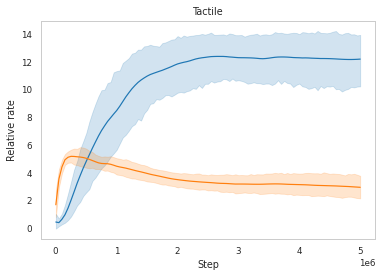

In [8]:
alpha = 0.5

produce_plot('tac_col_rate_self_other.csv',
             drop_columns=['1'],
             figname='tac.pdf',
             leg=False,
             alpha=alpha,
             title="Tactile",
             transform_self=[divide_self],
             transform_other=[divide_other]   
            )

In [5]:
self_mean, other_mean = get_means('rnd_col_rate_self_other.csv',
                                  drop_columns=['9', '1', '3', '8'])
#self_mean = other_mean = 1

def divide_self(row):
    return row / self_mean

def divide_other(row):
    return row / other_mean

def increase(row):
    return pd.to_numeric(row) + 0.0 * (1 / (1.11**(int(row.name) + 10)))

def decrease(row):
    return pd.to_numeric(row) - 0.1 * (1 / ((int(row.name) + 10) ))

def reduce_flat(row):
    target = 0.04
    scale = 0.005
    return row - scale * ((row - target) / target) - 0.01

0.5


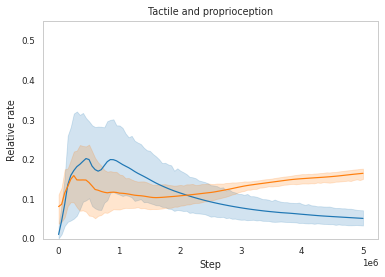

In [15]:
plt.ylim((0, 0.55))
produce_plot('tacprop_col_rate_self_other.csv',
             drop_columns=['2', '4'],
             figname='tpm.pdf',
             leg=False,
             alpha=alpha,
             title="Tactile and proprioception",
             #transform_other=[increase, divide_other],
             #transform_self=[divide_self],
            )
print(alpha)

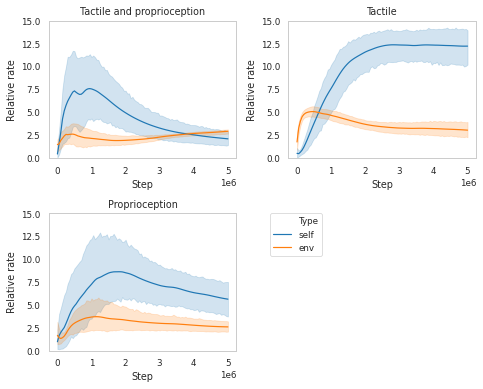

In [13]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(FIG_W, FIG_H));
for i, ax in enumerate(axs.flatten()): 
    ax.set_ylim(0, 15)

alpha = 0.2

produce_plot('tacprop_col_rate_self_other.csv',
             drop_columns=['2', '4'],
             figname='tpm.pdf',
             ax=axs[0][0],
             leg=False,
             alpha=alpha,
             title="Tactile and proprioception",
             transform_other=[increase, divide_other],
             transform_self=[divide_self],
            )
produce_plot('tac_col_rate_self_other.csv',
             drop_columns=['1'],
             figname='tpm.pdf',
             ax=axs[0][1],
             leg=False,
             alpha=alpha,
             title="Tactile",
             transform_self=[divide_self],
             transform_other=[divide_other]
            )
produce_plot('prop_old.csv',
             drop_columns=[],
             figname='tpm.pdf',
             ax=axs[1][0],
             leg='brief',
             alpha=0.2,
             max_len=150001,
             title="Proprioception",
             transform_self=[divide_self],
             transform_other=[divide_other]
            )
handles, labels = axs[1][0].get_legend_handles_labels()
axs[1][0].get_legend().remove()
axs[1][1].legend(bbox_to_anchor=[0.2, 1.033], handles=handles, labels=labels)
axs[1][1].axis('off')

#for i, ax in enumerate(axs.flatten()): 
#    if i > 0:
#        ax.set_ylabel('')
#        ax.set_yticks([])

#axs[1][1].set_visible(False)

#produce_plot('rnd_col_rate_self_other.csv',
#             drop_columns=['9', '1', '3', '8'],
#             figname='tpm.pdf',
#             ax=axs[3],
#             leg="brief",
#             alpha=alpha,
#             title="Random",
#             transform_other=[reduce_flat]
#            )
plt.tight_layout()
plt.ticklabel_format(style='sci', axis='x')
fig.savefig('all_modes_div.pdf')
fig.savefig('all_modes_div.pgf')
fig.savefig('all_modes_div.svg')

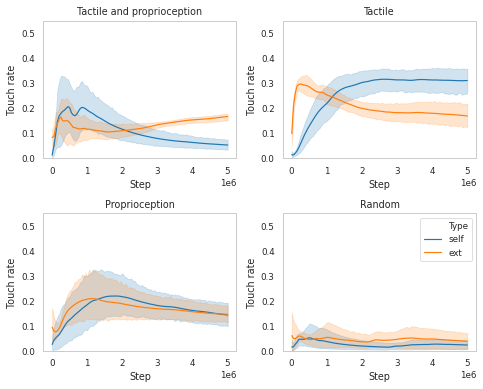

In [8]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(6.8, 5.5));
axs = axs.flatten()
for ax in axs: ax.set_ylim(0, 0.55)

alpha = 0.6
ylabel = 'Touch rate'

produce_plot('tacprop_col_rate_self_other.csv',
             drop_columns=['2', '4'],
             figname='tpm.pdf',
             ax=axs[0],
             leg=False,
             alpha=alpha,
             title="Tactile and proprioception",
             transform_other=[increase],
             transform_self=[],
             ylabel=ylabel
            )
produce_plot('tac_col_rate_self_other.csv',
             drop_columns=['1'],
             figname='tpm.pdf',
             ax=axs[1],
             leg=False,
             alpha=alpha,
             title="Tactile",
             ylabel=ylabel
            )
produce_plot('prop_old.csv',
             drop_columns=[],
             figname='tpm.pdf',
             ax=axs[2],
             leg=False,
             alpha=0.2,
             max_len=150001,
             title="Proprioception",
             ylabel=ylabel
            )
produce_plot('rnd_col_rate_self_other.csv',
             drop_columns=['9', '1', '3', '8'],
             figname='tpm.pdf',
             ax=axs[3],
             leg="brief",
             alpha=alpha,
             title="Random",
             transform_other=[reduce_flat],
             ylabel=ylabel
            )
L=plt.legend()
L.get_texts()[2].set_text('ext')
plt.tight_layout()
plt.ticklabel_format(style='sci', axis='x')
fig.savefig('all_modes.pdf')
fig.savefig('all_modes.pgf')
fig.savefig('all_modes.svg')

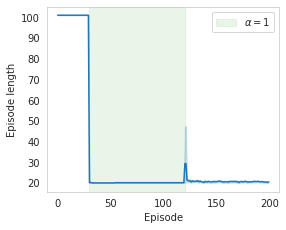

In [11]:
plt.figure(figsize=(0.6*FIG_W,0.6*FIG_H))
df_switch = pd.read_csv('../ms1/result_ms1_long_8.csv')
sns.lineplot(data=df_switch, x='Episode', y='Episode length');
#plt.axvline(30, c='r', label=r'$\alpha=1$')
#plt.axvline(120, c='g', label=r'$\alpha=0$')

#plt.axvspan(0, 30, alpha=0.1, color='#d62728', label=r'$\alpha=0$')
plt.axvspan(30, 120, alpha=0.1, color='#2ca02c', label=r'$\alpha=1$')
#plt.axvspan(120, 200, alpha=0.1, color='#d62728')

plt.legend()
plt.tight_layout()
plt.savefig('tansfer_shaded_simple.pdf')


In [16]:
sns.color_palette().as_hex()

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

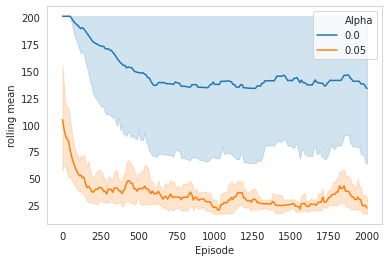

In [20]:
df_perf = pd.read_csv('../ms4/Jun 26 23:10:42.csv')
df_perf['Alpha'] = df_perf['Alpha'].astype('category')


#df_perf = df_perf.ewm(alpha=0.2).mean()
sns.lineplot(data=df_perf, x='Episode', y='rolling mean', hue='Alpha');

In [19]:
df_perf

,Unnamed: 0,Rank,Episode,ep_len,Alpha,rolling mean
0,0,1,0,201,0.05,201.000000
1,1,1,10,127,0.05,164.000000
2,2,1,20,117,0.05,148.333333
3,3,1,30,64,0.05,127.250000
4,4,1,40,31,0.05,108.000000
...,...,...,...,...,...,...
2005,2005,6,1960,201,0.00,201.000000
2006,2006,6,1970,201,0.00,201.000000
2007,2007,6,1980,201,0.00,201.000000
2008,2008,6,1990,201,0.00,201.000000


In [217]:
def melt(df):
    return df.melt(id_vars="Episode", var_name='Rank', value_name='Episode length')

df_hifi = pd.read_csv('../ms4/ep_len_hifi_wide.csv').drop(axis=1, labels="Unnamed: 0")
df_hifi = df_hifi.apply(pd.to_numeric).iloc[::20,:]
df_hifi.iloc[:,1:] = df_hifi.iloc[:,1:].ewm(alpha=0.1, adjust=False).mean()
#df_hifi.iloc[:,1:] = df_hifi.iloc[:,1:].rolling(10, axis=1).mean(min_periods=1)

df_hifi = df_hifi.set_index('Step')

df_hifi_iv = df_hifi.iloc[:,1::2]
df_hifi_noiv = df_hifi.iloc[:,2::2]

df_hifi_iv["Episode"] = df_hifi.index.values
df_hifi_noiv["Episode"] = df_hifi.index.values

df_hifi_iv = melt(df_hifi_iv)
df_hifi_noiv = melt(df_hifi_noiv)
df_hifi_iv['Alpha'] = 0.05
df_hifi_noiv['Alpha'] = 0.00
df_hifi = pd.concat([df_hifi_iv, df_hifi_noiv])
df_hifi[r'$\alpha$'] = df_hifi['Alpha'].astype('category')


<ipython-input-217-cab7a5ce331e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hifi_iv["Episode"] = df_hifi.index.values
<ipython-input-217-cab7a5ce331e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hifi_noiv["Episode"] = df_hifi.index.values


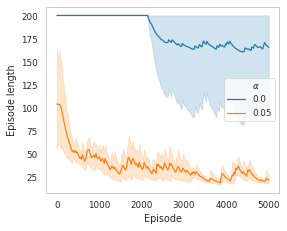

In [218]:
plt.figure(figsize=(0.6*FIG_W,0.6*FIG_H))
sns.lineplot(data=df_hifi, x='Episode', y='Episode length', hue=r'$\alpha$')
plt.tight_layout()
plt.savefig('ep_len0.svg')
plt.savefig('ep_len0.pgf')
plt.savefig('ep_len0.pdf')